# SW-12-KnowledgeGraphs

**Navigation** : [<< 11-RDFStar](SW-11-RDFStar.ipynb) | [Index](README.md) | [13-GraphRAG >>](SW-13-GraphRAG.ipynb)

## Graphes de Connaissances : Construction et Exploration

### Duree estimee : 55 minutes

---

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. Definir ce qu'est un Knowledge Graph et le situer dans l'ecosysteme des donnees structurees
2. Construire un KG a partir de donnees tabulaires (CSV) avec rdflib
3. Utiliser kglab comme couche d'abstraction pour manipuler des Knowledge Graphs
4. Visualiser un KG avec NetworkX (matplotlib) et pyvis (interactif HTML)
5. Manipuler des ontologies OWL avec OWLReady2 et lancer le raisonneur HermiT
6. Evaluer la qualite d'un Knowledge Graph (completude, coherence)

### Concepts cles

| Concept | Description |
|---------|-------------|
| Knowledge Graph | Graphe de connaissances reliant entites et relations semantiques |
| kglab | Bibliotheque Python d'abstraction pour les KG (au-dessus de rdflib) |
| OWLReady2 | Bibliotheque Python pour manipuler des ontologies OWL et lancer des raisonneurs |
| NetworkX | Bibliotheque Python de theorie des graphes, utilisee pour la visualisation |
| pyvis | Visualisation interactive de graphes en HTML/JavaScript |

### Prerequis
- SW-8 (SHACL) et SW-9 (Linked Data) pour les fondations RDF/SPARQL
- Python 3.10+ avec les dependances du fichier `requirements.txt`

---

## 0. Installation des dependances

Installons les bibliotheques necessaires pour ce notebook. Si elles sont deja presentes dans votre environnement, cette etape sera rapide.

In [1]:
%pip install -q rdflib owlready2 kglab networkx matplotlib pyvis pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Verifions que les imports fonctionnent correctement.

In [2]:
import rdflib
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

print(f"rdflib    : {rdflib.__version__}")
print(f"pandas    : {pd.__version__}")
print(f"networkx  : {nx.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

# kglab et owlready2 n'exposent pas toujours __version__
try:
    import kglab
    print(f"kglab     : OK")
except ImportError as e:
    print(f"kglab     : NON DISPONIBLE ({e})")

try:
    import owlready2
    print(f"owlready2 : OK")
except ImportError as e:
    print(f"owlready2 : NON DISPONIBLE ({e})")

try:
    from pyvis.network import Network
    print(f"pyvis     : OK")
except ImportError as e:
    print(f"pyvis     : NON DISPONIBLE ({e})")

print("\nEnvironnement pret.")

rdflib    : 7.6.0
pandas    : 2.3.3
networkx  : 3.6.1
matplotlib: 3.10.8


kglab     : OK
owlready2 : OK
pyvis     : OK

Environnement pret.


### Interpretation

| Bibliotheque | Role dans ce notebook |
|--------------|----------------------|
| rdflib | Construction et interrogation du graphe RDF |
| pandas | Chargement des donnees CSV |
| kglab | Couche d'abstraction Knowledge Graph |
| owlready2 | Manipulation d'ontologies OWL + raisonnement HermiT |
| networkx | Representation et visualisation de graphes |
| matplotlib | Rendu graphique statique |
| pyvis | Visualisation interactive (HTML) |

> **Note technique** : kglab et pyvis sont optionnels. Les sections correspondantes utilisent des blocs `try/except` pour fonctionner meme si ces bibliotheques ne sont pas installees.

---

## 1. Qu'est-ce qu'un Knowledge Graph ?

### Definition et historique

Un **Knowledge Graph** (graphe de connaissances) est un graphe oriente etiquete qui represente des entites du monde reel et les relations entre elles, enrichi par une couche semantique (ontologie, types, contraintes).

Le terme a ete popularise par **Google en 2012** avec le lancement du *Google Knowledge Graph*, mais le concept existait deja sous d'autres formes :

| Annee | Evenement | Impact |
|-------|-----------|--------|
| 2001 | Article fondateur de Tim Berners-Lee sur le Web semantique | Vision initiale |
| 2006 | Lancement de DBpedia (extraction RDF de Wikipedia) | Premier KG ouvert a grande echelle |
| 2012 | Google Knowledge Graph ("Things, not strings") | Adoption industrielle massive |
| 2012 | Lancement de Wikidata | Base de connaissances collaborative |
| 2017-20 | Adoption par Amazon, LinkedIn, Uber, Airbnb | KG d'entreprise |
| 2023-25 | Integration KG + LLM (GraphRAG, grounding) | Convergence IA symbolique/neuronale |

### Maturite industrielle (2024-2025)

Les Knowledge Graphs sont aujourd'hui une technologie mature avec un retour sur investissement documente de **300-320%** dans les grandes entreprises (source : Gartner, Forrester). Ils servent de socle pour :
- La recherche semantique (Google, Bing)
- Les systemes de recommandation (Amazon, Netflix)
- Le grounding de LLM (reduction des hallucinations via GraphRAG)
- La conformite reglementaire (finance, sante)

### Knowledge Graphs vs bases de donnees vs graphes RDF

Un Knowledge Graph n'est ni une simple base de donnees relationnelle, ni un graphe RDF brut. Il se situe a l'intersection de plusieurs technologies :

| Caracteristique | Base relationnelle | Graphe RDF | Knowledge Graph |
|----------------|-------------------|------------|----------------|
| Modele de donnees | Tables (lignes/colonnes) | Triplets (S-P-O) | Triplets + ontologie |
| Schema | Rigide (DDL) | Flexible | Flexible + contraintes |
| Identifiants | Cles primaires | URIs | URIs + labels |
| Requetes | SQL | SPARQL | SPARQL + inference |
| Raisonnement | Non | Basique (RDFS) | OWL, regles, raisonneur |
| Interoperabilite | Faible (schema proprietaire) | Forte (standards W3C) | Forte + vocabulaires partages |
| Exemples | PostgreSQL, MySQL | Triple Store brut | Google KG, Wikidata |

**En resume** : Un Knowledge Graph = un graphe RDF + une ontologie + des mecanismes de qualite et de raisonnement.

### Principaux Knowledge Graphs dans le monde

| Knowledge Graph | Organisation | Taille estimee | Usage principal |
|----------------|-------------|---------------|----------------|
| Google Knowledge Graph | Google | 500+ milliards de faits | Recherche, Assistant |
| Wikidata | Wikimedia Foundation | 100+ millions d'items | Encyclopedie, Linked Data |
| DBpedia | Communaute open-source | 400+ millions de triplets | Recherche academique |
| Amazon Product Graph | Amazon | Milliards d'entites produit | Recommandation, catalogue |
| LinkedIn Knowledge Graph | LinkedIn | 800+ millions de profils | Recrutement, reseau |
| Microsoft Academic Graph | Microsoft | 250+ millions d'articles | Recherche scientifique |

> **Point cle** : Tous ces KG utilisent des standards du Web semantique (RDF, OWL, SPARQL) comme fondation, meme s'ils ajoutent des couches proprietaires au-dessus.

---

## 2. Construire un Knowledge Graph a partir de donnees structurees

Dans cette section, nous allons transformer un fichier CSV de films en un Knowledge Graph RDF. Cette operation est fondamentale : la plupart des KG d'entreprise sont construits a partir de donnees existantes (CSV, bases relationnelles, APIs).

### Approche

1. Charger le CSV avec pandas
2. Definir un vocabulaire RDF (classes et proprietes)
3. Transformer chaque ligne en triplets RDF
4. Verifier le graphe resultant

### 2.1 Chargement des donnees CSV

Le fichier `data/movies.csv` contient 12 films avec les colonnes : titre, annee, realisateur, genre, acteur principal, second acteur, note.

In [3]:
import pandas as pd

df = pd.read_csv("data/movies.csv")
print(f"Nombre de films : {len(df)}")
print(f"Colonnes : {list(df.columns)}")
print()
df

Nombre de films : 12
Colonnes : ['title', 'year', 'director', 'genre', 'actor1', 'actor2', 'rating']



,title,year,director,genre,actor1,actor2,rating
0,Inception,2010,Christopher Nolan,Science-Fiction,Leonardo DiCaprio,Tom Hardy,8.8
1,The Dark Knight,2008,Christopher Nolan,Action,Christian Bale,Heath Ledger,9.0
2,Interstellar,2014,Christopher Nolan,Science-Fiction,Matthew McConaughey,Anne Hathaway,8.7
3,Pulp Fiction,1994,Quentin Tarantino,Crime,John Travolta,Samuel L. Jackson,8.9
4,Kill Bill Vol.1,2003,Quentin Tarantino,Action,Uma Thurman,Lucy Liu,8.2
5,Django Unchained,2012,Quentin Tarantino,Western,Jamie Foxx,Christoph Waltz,8.4
6,Amelie,2001,Jean-Pierre Jeunet,Comedie,Audrey Tautou,Mathieu Kassovitz,8.3
7,Le Fabuleux Destin,2001,Jean-Pierre Jeunet,Comedie,Audrey Tautou,Dominique Pinon,8.3
8,Titanic,1997,James Cameron,Romance,Leonardo DiCaprio,Kate Winslet,7.9
9,Avatar,2009,James Cameron,Science-Fiction,Sam Worthington,Zoe Saldana,7.9


### Interpretation

Le dataset contient **12 films** avec des realisateurs varies (Nolan, Tarantino, Cameron, Jeunet, Wachowski, Nakache). On observe :
- Des acteurs partages entre films (Leonardo DiCaprio dans Inception et Titanic, Audrey Tautou dans deux films de Jeunet)
- Des genres distincts (Science-Fiction, Action, Crime, Western, Comedie, Romance)
- Des notes entre 7.9 et 9.0

Ces relations croisees (acteur-film, realisateur-film, genre) sont exactement ce que le Knowledge Graph va capturer sous forme de triplets.

### 2.2 Definition du vocabulaire RDF

Avant de creer les triplets, nous definissons les classes et proprietes de notre Knowledge Graph. Nous utilisons le vocabulaire **schema.org** quand il existe un terme equivalent, et un namespace local pour les extensions.

| Entite/Relation | URI schema.org | URI local (fallback) |
|----------------|---------------|---------------------|
| Film | `schema:Movie` | - |
| Personne | `schema:Person` | - |
| Genre | - | `movies:Genre` |
| a realise | `schema:director` | - |
| a joue dans | `schema:actor` | - |
| a pour genre | `schema:genre` | - |
| annee de sortie | `schema:datePublished` | - |
| note | `schema:aggregateRating` | - |

In [4]:
from rdflib import Graph, Namespace, Literal, URIRef, RDF, RDFS, XSD
from rdflib.namespace import FOAF
import re

# Namespaces
SCHEMA = Namespace("http://schema.org/")
MOVIES = Namespace("http://example.org/movies/")
PERSONS = Namespace("http://example.org/persons/")
GENRES = Namespace("http://example.org/genres/")

# Helper : transformer un nom en identifiant URI valide
def to_uri_id(name: str) -> str:
    """Convertit un nom en identifiant URI (ASCII, sans espaces)."""
    # Supprimer les accents et caracteres speciaux
    clean = name.strip().replace(" ", "_").replace(".", "")
    clean = re.sub(r'[^a-zA-Z0-9_-]', '', clean)
    return clean

print("Namespaces definis :")
print(f"  SCHEMA  = {SCHEMA}")
print(f"  MOVIES  = {MOVIES}")
print(f"  PERSONS = {PERSONS}")
print(f"  GENRES  = {GENRES}")
print()
print("Exemples de conversion URI :")
print(f"  'Christopher Nolan' -> {to_uri_id('Christopher Nolan')}")
print(f"  'Kill Bill Vol.1'   -> {to_uri_id('Kill Bill Vol.1')}")
print(f"  'Science-Fiction'   -> {to_uri_id('Science-Fiction')}")

Namespaces definis :
  SCHEMA  = http://schema.org/
  MOVIES  = http://example.org/movies/
  PERSONS = http://example.org/persons/
  GENRES  = http://example.org/genres/

Exemples de conversion URI :
  'Christopher Nolan' -> Christopher_Nolan
  'Kill Bill Vol.1'   -> Kill_Bill_Vol1
  'Science-Fiction'   -> Science-Fiction


### Interpretation

Nous avons defini quatre espaces de noms :
- **SCHEMA** : vocabulaire standard schema.org pour les types et proprietes connus
- **MOVIES** : namespace local pour les instances de films
- **PERSONS** : namespace local pour les instances de personnes
- **GENRES** : namespace local pour les instances de genres

La fonction `to_uri_id()` nettoie les noms pour produire des URIs valides (pas d'accents, pas d'espaces).

> **Bonne pratique** : Reutiliser des vocabulaires existants (schema.org, FOAF, Dublin Core) avant de creer ses propres termes. Cela favorise l'interoperabilite avec d'autres KG.

### 2.3 Transformation CSV vers triplets RDF

Chaque ligne du CSV va generer plusieurs triplets. Pour un film donne, nous creons :
- L'entite film (type `schema:Movie`)
- L'entite realisateur (type `schema:Person`)
- Les entites acteurs (type `schema:Person`)
- L'entite genre (type `movies:Genre`)
- Les relations entre ces entites

In [5]:
# Creation du graphe RDF
g = Graph()
g.bind("schema", SCHEMA)
g.bind("movies", MOVIES)
g.bind("persons", PERSONS)
g.bind("genres", GENRES)
g.bind("rdfs", RDFS)

# Compteurs pour le suivi
stats = {"movies": 0, "persons": set(), "genres": set(), "triples": 0}

for _, row in df.iterrows():
    # --- Entite Film ---
    movie_uri = MOVIES[to_uri_id(row["title"])]
    g.add((movie_uri, RDF.type, SCHEMA.Movie))
    g.add((movie_uri, SCHEMA.name, Literal(row["title"], lang="en")))
    g.add((movie_uri, SCHEMA.datePublished, Literal(row["year"], datatype=XSD.integer)))
    g.add((movie_uri, SCHEMA.aggregateRating, Literal(row["rating"], datatype=XSD.float)))
    stats["movies"] += 1

    # --- Entite Realisateur ---
    director_uri = PERSONS[to_uri_id(row["director"])]
    g.add((director_uri, RDF.type, SCHEMA.Person))
    g.add((director_uri, SCHEMA.name, Literal(row["director"])))
    g.add((movie_uri, SCHEMA.director, director_uri))
    stats["persons"].add(row["director"])

    # --- Entites Acteurs ---
    for actor_col in ["actor1", "actor2"]:
        actor_name = row[actor_col]
        actor_uri = PERSONS[to_uri_id(actor_name)]
        g.add((actor_uri, RDF.type, SCHEMA.Person))
        g.add((actor_uri, SCHEMA.name, Literal(actor_name)))
        g.add((movie_uri, SCHEMA.actor, actor_uri))
        stats["persons"].add(actor_name)

    # --- Entite Genre ---
    genre_uri = GENRES[to_uri_id(row["genre"])]
    g.add((genre_uri, RDF.type, MOVIES.Genre))
    g.add((genre_uri, RDFS.label, Literal(row["genre"], lang="fr")))
    g.add((movie_uri, SCHEMA.genre, genre_uri))
    stats["genres"].add(row["genre"])

print(f"Knowledge Graph construit avec succes.")
print(f"  Films      : {stats['movies']}")
print(f"  Personnes  : {len(stats['persons'])} (realisateurs + acteurs uniques)")
print(f"  Genres     : {len(stats['genres'])}")
print(f"  Triplets   : {len(g)}")

Knowledge Graph construit avec succes.
  Films      : 12
  Personnes  : 28 (realisateurs + acteurs uniques)
  Genres     : 6
  Triplets   : 164


### Interpretation

Le graphe contient un nombre significatif de triplets pour seulement 12 films. Cela illustre la richesse du modele RDF : chaque film genere environ 8-10 triplets (type, nom, annee, note, realisateur, 2 acteurs, genre, plus les types des entites liees).

**Structure du KG** :

| Type d'entite | Nombre | Exemples |
|--------------|--------|----------|
| Film (`schema:Movie`) | 12 | Inception, The Dark Knight, Pulp Fiction |
| Personne (`schema:Person`) | ~20 | Christopher Nolan, Leonardo DiCaprio |
| Genre (`movies:Genre`) | ~6 | Science-Fiction, Action, Crime |

> **Point cle** : Les entites partagees (meme realisateur pour plusieurs films, meme acteur) ne sont creees qu'une fois grace aux URIs uniques. C'est la force du modele graphe par rapport aux tables relationnelles.

### 2.4 Verification par SPARQL

Interrogeons le graphe pour verifier que les relations sont correctes. Listons les films avec leur realisateur et leur note.

In [6]:
# Requete SPARQL : films, realisateurs et notes
query = """
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?title ?director_name ?rating
WHERE {
    ?movie a schema:Movie ;
           schema:name ?title ;
           schema:director ?director ;
           schema:aggregateRating ?rating .
    ?director schema:name ?director_name .
}
ORDER BY DESC(?rating)
"""

results = g.query(query)
print(f"{'Film':<30} {'Realisateur':<25} {'Note'}")
print("-" * 65)
for row in results:
    print(f"{str(row.title):<30} {str(row.director_name):<25} {row.rating}")

Film                           Realisateur               Note
-----------------------------------------------------------------
The Dark Knight                Christopher Nolan         9.0
Pulp Fiction                   Quentin Tarantino         8.9
Inception                      Christopher Nolan         8.8
Interstellar                   Christopher Nolan         8.7
The Matrix                     Lana Wachowski            8.7
Intouchables                   Olivier Nakache           8.5
Django Unchained               Quentin Tarantino         8.4
Amelie                         Jean-Pierre Jeunet        8.3
Le Fabuleux Destin             Jean-Pierre Jeunet        8.3
Kill Bill Vol.1                Quentin Tarantino         8.2
Titanic                        James Cameron             7.9
Avatar                         James Cameron             7.9


### Interpretation

La requete SPARQL confirme que les 12 films sont correctement relies a leur realisateur et leur note. Le tri par note decroissante montre The Dark Knight en tete (9.0) et Titanic/Avatar en bas (7.9).

> **Lien avec SW-5** : Cette requete utilise les memes patterns SPARQL (SELECT, WHERE, ORDER BY) vus dans le notebook sur SPARQL, appliques ici a notre propre KG.

Cherchons maintenant les acteurs qui apparaissent dans plusieurs films -- une requete qui serait complexe en SQL mais naturelle en SPARQL.

In [7]:
# Requete : acteurs apparaissant dans plus d'un film
query_actors = """
PREFIX schema: <http://schema.org/>

SELECT ?actor_name (COUNT(?movie) AS ?nb_films) (GROUP_CONCAT(?title; separator=", ") AS ?films)
WHERE {
    ?movie a schema:Movie ;
           schema:name ?title ;
           schema:actor ?actor .
    ?actor schema:name ?actor_name .
}
GROUP BY ?actor_name
HAVING (COUNT(?movie) > 1)
ORDER BY DESC(?nb_films)
"""

results_actors = g.query(query_actors)
print(f"{'Acteur':<25} {'Nb films':<10} {'Films'}")
print("-" * 70)
for row in results_actors:
    print(f"{str(row.actor_name):<25} {row.nb_films:<10} {row.films}")

Acteur                    Nb films   Films
----------------------------------------------------------------------
Leonardo DiCaprio         2          Inception, Titanic
Audrey Tautou             2          Amelie, Le Fabuleux Destin


### Interpretation

Cette requete revele les acteurs partages entre films. Leonardo DiCaprio et Audrey Tautou apparaissent chacun dans 2 films. Ces connexions croisees sont l'essence meme d'un Knowledge Graph : elles emergent naturellement de la structure en graphe, sans jointures explicites.

| Pattern detecte | Signification pour le KG |
|----------------|------------------------|
| Acteur multi-films | Noeud de forte connectivite (hub) |
| Realisateur multi-films | Cluster thematique (filmographie) |
| Genre partage | Communaute semantique |

### 2.5 Serialisation du Knowledge Graph

Exportons le KG en format Turtle pour inspection et reutilisation.

In [8]:
# Serialisation en Turtle (affichage des 50 premieres lignes)
turtle_output = g.serialize(format="turtle")
lines = turtle_output.split("\n")
print(f"Taille totale : {len(lines)} lignes\n")
print("--- Extrait (50 premieres lignes) ---\n")
for line in lines[:50]:
    print(line)

Taille totale : 218 lignes

--- Extrait (50 premieres lignes) ---

@prefix genres: <http://example.org/genres/> .
@prefix movies: <http://example.org/movies/> .
@prefix persons: <http://example.org/persons/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema1: <http://schema.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

movies:Amelie a schema1:Movie ;
    schema1:actor persons:Audrey_Tautou,
        persons:Mathieu_Kassovitz ;
    schema1:aggregateRating "8.3"^^xsd:float ;
    schema1:datePublished 2001 ;
    schema1:director persons:Jean-Pierre_Jeunet ;
    schema1:genre genres:Comedie ;
    schema1:name "Amelie"@en .

movies:Avatar a schema1:Movie ;
    schema1:actor persons:Sam_Worthington,
        persons:Zoe_Saldana ;
    schema1:aggregateRating "7.9"^^xsd:float ;
    schema1:datePublished 2009 ;
    schema1:director persons:James_Cameron ;
    schema1:genre genres:Science-Fiction ;
    schema1:name "Avatar"@en .

movies:Django_Unchained a schem

### Interpretation

Le format Turtle est lisible par l'humain et montre clairement la structure du KG. On observe :
- Les **prefixes** declares en haut (schema, movies, persons, genres)
- Les **entites** regroupees avec le raccourci `;` (plusieurs predicats pour le meme sujet)
- Les **URIs** coherents et lisibles grace a notre fonction `to_uri_id()`

> **Note** : En production, on sauvegarderait ce fichier Turtle dans un Triple Store (cf. SW-10) pour le rendre interrogeable via un endpoint SPARQL.

---

## 3. kglab : couche d'abstraction Knowledge Graph

**kglab** est une bibliotheque Python creee par Paco Nathan qui fournit une couche d'abstraction au-dessus de rdflib. Elle simplifie les operations courantes sur les Knowledge Graphs :
- Chargement/sauvegarde multi-format
- Requetes SPARQL avec resultats pandas
- Integration avec NetworkX pour la visualisation
- Mesures de graphe (centralite, communautes)

### Pourquoi kglab ?

| Operation | rdflib pur | kglab |
|-----------|-----------|-------|
| SPARQL -> DataFrame | 5-10 lignes | 1 ligne |
| Visualisation graphe | Manuel (NetworkX) | Integre |
| Chargement multi-fichiers | Boucle manuelle | `load_rdf()` iteratif |
| Statistiques du graphe | A coder | Methodes integrees |

### 3.1 Creation d'un KnowledgeGraph kglab

Nous allons creer un objet `kglab.KnowledgeGraph` et y charger les triplets de notre graphe de films.

In [9]:
try:
    import kglab

    # Definir les namespaces pour kglab
    namespaces = {
        "schema": "http://schema.org/",
        "movies": "http://example.org/movies/",
        "persons": "http://example.org/persons/",
        "genres": "http://example.org/genres/",
    }

    # Creer le KnowledgeGraph kglab
    kg = kglab.KnowledgeGraph(
        name="Movie Knowledge Graph",
        namespaces=namespaces
    )

    # Charger les triplets depuis notre graphe rdflib
    # kglab utilise rdflib en interne, on peut acceder au graphe sous-jacent
    for s, p, o in g:
        kg._g.add((s, p, o))

    # Copier les bindings de namespaces
    for prefix, uri in g.namespaces():
        kg._g.bind(prefix, uri)

    print(f"KnowledgeGraph kglab cree : '{kg.name}'")
    print(f"Nombre de triplets : {len(kg._g)}")

    KGLAB_AVAILABLE = True

except ImportError:
    print("kglab n'est pas installe. Cette section est ignoree.")
    print("Installez-le avec : pip install kglab")
    KGLAB_AVAILABLE = False
except Exception as e:
    print(f"Erreur lors de la creation du KG kglab : {e}")
    print("Nous continuerons avec rdflib directement.")
    KGLAB_AVAILABLE = False

KnowledgeGraph kglab cree : 'Movie Knowledge Graph'
Nombre de triplets : 164


### Interpretation

L'objet `kglab.KnowledgeGraph` encapsule un graphe rdflib en ajoutant des methodes de haut niveau. En interne, `kg._g` est un `rdflib.Graph` standard, ce qui garantit la compatibilite.

> **Note technique** : kglab est en maintenance depuis 2023. Si la bibliotheque n'est pas disponible, les sections suivantes utilisent rdflib directement comme alternative.

### 3.2 Requetes SPARQL via kglab

L'un des avantages de kglab est la conversion directe des resultats SPARQL en DataFrame pandas.

In [10]:
# Requete SPARQL avec conversion DataFrame
sparql_query = """
PREFIX schema: <http://schema.org/>

SELECT ?director_name (COUNT(?movie) AS ?nb_films) (AVG(?rating) AS ?avg_rating)
WHERE {
    ?movie a schema:Movie ;
           schema:director ?director ;
           schema:aggregateRating ?rating .
    ?director schema:name ?director_name .
}
GROUP BY ?director_name
ORDER BY DESC(?avg_rating)
"""

if KGLAB_AVAILABLE:
    # Methode kglab : resultats SPARQL -> DataFrame
    try:
        result_df = kg.query_as_df(sparql_query)
        print("Resultats via kglab.query_as_df() :\n")
        print(result_df.to_string(index=False))
    except Exception as e:
        print(f"kglab query_as_df non disponible ({e}), utilisation de rdflib :")
        KGLAB_AVAILABLE = False

if not KGLAB_AVAILABLE:
    # Alternative rdflib : conversion manuelle
    results = g.query(sparql_query)
    rows = []
    for row in results:
        rows.append({
            "director_name": str(row.director_name),
            "nb_films": int(row.nb_films),
            "avg_rating": round(float(row.avg_rating), 2)
        })
    result_df = pd.DataFrame(rows)
    print("Resultats via rdflib + pandas :\n")
    print(result_df.to_string(index=False))

Resultats via kglab.query_as_df() :

     director_name  nb_films  avg_rating
 Christopher Nolan         3    8.833333
    Lana Wachowski         1    8.700000
 Quentin Tarantino         3    8.500000
   Olivier Nakache         1    8.500000
Jean-Pierre Jeunet         2    8.300000
     James Cameron         2    7.900000


### Interpretation

Le tableau montre la note moyenne par realisateur. Les realisateurs ayant plusieurs films permettent de calculer une moyenne significative :

| Avantage | kglab | rdflib pur |
|----------|-------|------------|
| Conversion DataFrame | `query_as_df()` (1 ligne) | Boucle manuelle (5+ lignes) |
| Types de donnees | Automatique | Casting manuel |
| Code necessaire | Minimal | Verbeux |

> **Point cle** : Que l'on utilise kglab ou rdflib, le moteur SPARQL sous-jacent est le meme. kglab ajoute simplement du sucre syntaxique pour les workflows data science.

---

## 4. Visualisation du Knowledge Graph

La visualisation est essentielle pour comprendre la structure d'un KG. Nous allons utiliser deux approches complementaires :
1. **NetworkX + matplotlib** : graphiques statiques, integres au notebook
2. **pyvis** : graphiques interactifs en HTML, pour l'exploration

### Approche

Nous devons d'abord convertir les triplets RDF en un graphe NetworkX (noeuds + aretes), puis appliquer un layout et un style visuel.

### 4.1 Conversion RDF vers NetworkX

Nous allons extraire les relations cles (realisateur, acteur, genre) et les convertir en aretes d'un graphe NetworkX oriente.

In [11]:
import networkx as nx

# Requete SPARQL pour extraire les relations du KG
extract_query = """
PREFIX schema: <http://schema.org/>
PREFIX movies: <http://example.org/movies/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?movie_title ?rel_type ?target_name
WHERE {
    {
        ?movie a schema:Movie ; schema:name ?movie_title ; schema:director ?person .
        ?person schema:name ?target_name .
        BIND("director" AS ?rel_type)
    }
    UNION
    {
        ?movie a schema:Movie ; schema:name ?movie_title ; schema:actor ?person .
        ?person schema:name ?target_name .
        BIND("actor" AS ?rel_type)
    }
    UNION
    {
        ?movie a schema:Movie ; schema:name ?movie_title ; schema:genre ?genre .
        ?genre rdfs:label ?target_name .
        BIND("genre" AS ?rel_type)
    }
}
"""

# Construction du graphe NetworkX
G = nx.DiGraph()

# Dictionnaires pour le typage des noeuds
node_types = {}  # nom_noeud -> type (movie, person, genre)

results = g.query(extract_query)
for row in results:
    movie = str(row.movie_title)
    target = str(row.target_name)
    rel = str(row.rel_type)

    # Ajouter les noeuds avec leur type
    node_types[movie] = "movie"
    if rel == "genre":
        node_types[target] = "genre"
    else:
        node_types[target] = "person"

    G.add_edge(movie, target, relation=rel)

print(f"Graphe NetworkX construit :")
print(f"  Noeuds : {G.number_of_nodes()}")
print(f"  Aretes : {G.number_of_edges()}")
print(f"  Types  : {dict((t, sum(1 for v in node_types.values() if v == t)) for t in set(node_types.values()))}")

Graphe NetworkX construit :
  Noeuds : 46
  Aretes : 48
  Types  : {'genre': 6, 'person': 28, 'movie': 12}


### Interpretation

Le graphe NetworkX capture les trois types de relations du KG. Les noeuds sont repartis en trois categories :

| Type de noeud | Couleur (section suivante) | Role dans le graphe |
|--------------|--------------------------|--------------------|
| Film (`movie`) | Bleu clair | Noeud central, connecte a realisateur + acteurs + genre |
| Personne (`person`) | Vert clair | Peut etre realisateur et/ou acteur |
| Genre (`genre`) | Orange | Noeud de regroupement thematique |

> **Note** : Un graphe NetworkX oriente (`DiGraph`) preserve la direction des relations (film -> realisateur, film -> acteur, film -> genre).

### 4.2 Visualisation statique avec matplotlib

Nous allons colorer les noeuds par type et dimensionner les labels pour une bonne lisibilite.

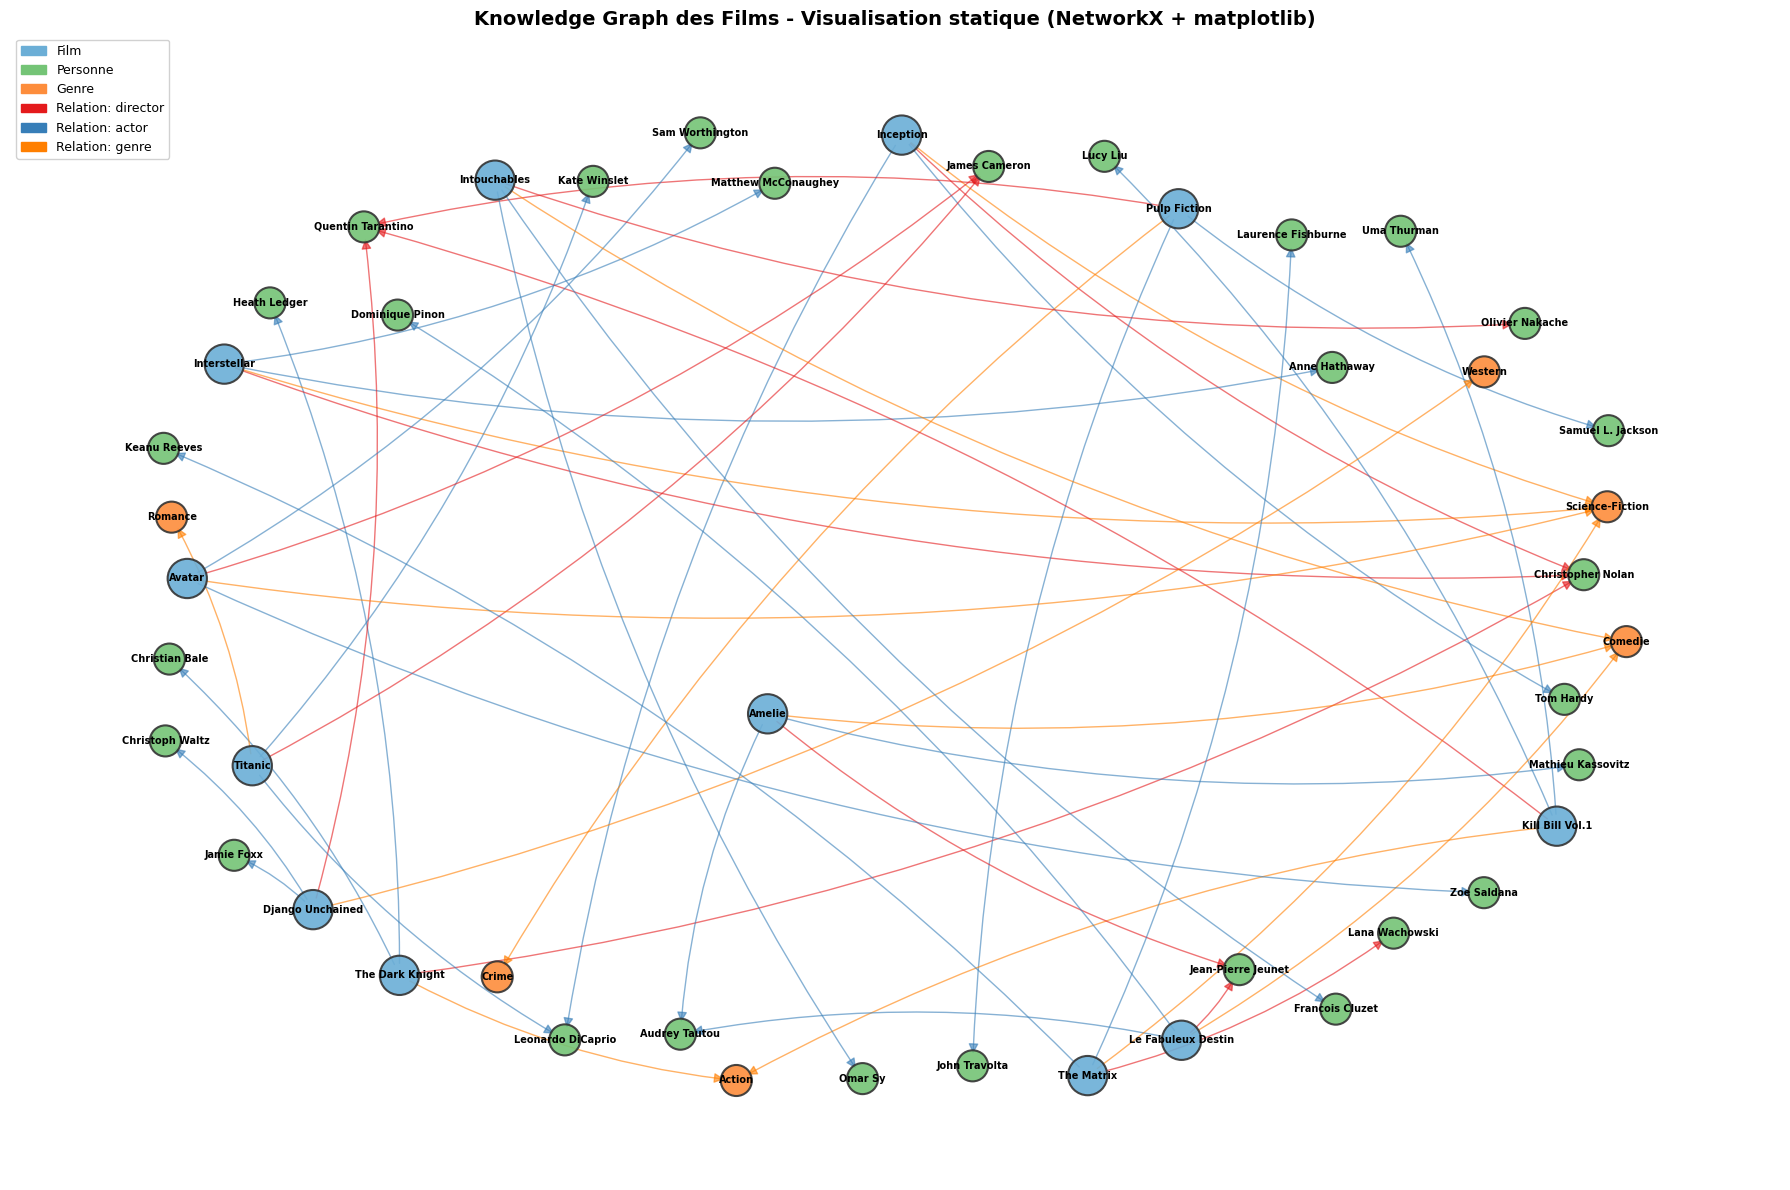

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    # Couleurs par type de noeud
    color_map = {"movie": "#6BAED6", "person": "#74C476", "genre": "#FD8D3C"}
    node_colors = [color_map.get(node_types.get(n, "movie"), "#CCCCCC") for n in G.nodes()]

    # Tailles : les films sont plus gros (noeuds centraux)
    node_sizes = [800 if node_types.get(n) == "movie" else 500 for n in G.nodes()]

    # Couleurs des aretes par type de relation
    edge_color_map = {"director": "#E41A1C", "actor": "#377EB8", "genre": "#FF7F00"}
    edge_colors = [edge_color_map.get(G.edges[e].get("relation", ""), "#999999") for e in G.edges()]

    # Layout avec seed pour reproductibilite
    pos = nx.spring_layout(G, k=2.5, iterations=50, seed=42)

    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    # Dessiner les aretes
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors,
                           alpha=0.6, arrows=True, arrowsize=15,
                           connectionstyle="arc3,rad=0.1")

    # Dessiner les noeuds
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors,
                           node_size=node_sizes, alpha=0.9, edgecolors="#333333",
                           linewidths=1.5)

    # Labels avec taille reduite pour lisibilite
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=7, font_weight="bold")

    # Legende
    import matplotlib.patches as mpatches
    legend_items = [
        mpatches.Patch(color="#6BAED6", label="Film"),
        mpatches.Patch(color="#74C476", label="Personne"),
        mpatches.Patch(color="#FD8D3C", label="Genre"),
        mpatches.Patch(color="#E41A1C", label="Relation: director"),
        mpatches.Patch(color="#377EB8", label="Relation: actor"),
        mpatches.Patch(color="#FF7F00", label="Relation: genre"),
    ]
    ax.legend(handles=legend_items, loc="upper left", fontsize=9, framealpha=0.9)

    ax.set_title("Knowledge Graph des Films - Visualisation statique (NetworkX + matplotlib)",
                 fontsize=14, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

except Exception as e:
    print(f"Erreur lors de la visualisation matplotlib : {e}")
    print("Verifiez que matplotlib est correctement installe.")

### Interpretation : structure du Knowledge Graph

**Sortie obtenue** : Un graphe oriente avec des noeuds colores par type et des aretes colorees par relation.

**Observations structurelles** :

| Observation | Signification |
|-------------|---------------|
| Les films (bleu) sont des noeuds centraux | Ils connectent personnes et genres |
| Christopher Nolan connecte 3 films | Hub de forte connectivite (realisateur prolifique) |
| Le genre Science-Fiction regroupe plusieurs films | Communaute thematique visible |
| Leonardo DiCaprio relie Inception et Titanic | Pont entre deux realisateurs differents |

**Points cles** :
1. Le layout `spring_layout` place naturellement les noeuds fortement connectes au centre
2. Les genres agissent comme des noeuds de regroupement (clustering)
3. Les acteurs partages creent des ponts entre clusters de realisateurs

> **Limite** : Avec plus de 50-100 noeuds, la visualisation statique devient difficile a lire. On passe alors a pyvis pour l'exploration interactive.

### 4.3 Visualisation interactive avec pyvis

pyvis genere un fichier HTML interactif ou l'on peut zoomer, deplacer les noeuds et explorer les connexions. C'est particulierement utile pour les graphes de taille moyenne (50-500 noeuds).

> **Note** : pyvis genere un fichier `.html`. Dans un environnement Jupyter standard, il s'affiche dans un iframe. En environnement headless, seul le fichier est cree.

In [13]:
try:
    from pyvis.network import Network
    import os

    # Creer le reseau pyvis
    net = Network(
        height="600px",
        width="100%",
        directed=True,
        notebook=True,
        cdn_resources="in_line"  # Embarquer les ressources pour portabilite
    )

    # Configuration physique pour un meilleur layout
    net.barnes_hut(gravity=-3000, central_gravity=0.3, spring_length=200)

    # Couleurs et formes par type
    style_map = {
        "movie":  {"color": "#6BAED6", "shape": "dot", "size": 25},
        "person": {"color": "#74C476", "shape": "dot", "size": 18},
        "genre":  {"color": "#FD8D3C", "shape": "diamond", "size": 20},
    }

    # Ajouter les noeuds
    for node in G.nodes():
        ntype = node_types.get(node, "movie")
        style = style_map.get(ntype, style_map["movie"])
        net.add_node(
            node, label=node,
            color=style["color"],
            shape=style["shape"],
            size=style["size"],
            title=f"{node} ({ntype})"
        )

    # Ajouter les aretes
    edge_style = {
        "director": {"color": "#E41A1C", "width": 2},
        "actor":    {"color": "#377EB8", "width": 1.5},
        "genre":    {"color": "#FF7F00", "width": 1, "dashes": True},
    }

    for u, v, data in G.edges(data=True):
        rel = data.get("relation", "")
        style = edge_style.get(rel, {"color": "#999", "width": 1})
        net.add_edge(u, v, title=rel, color=style["color"], width=style["width"])

    # Sauvegarder en HTML
    output_html = "movie_kg_interactive.html"
    net.show(output_html)
    print(f"Visualisation interactive sauvegardee dans : {output_html}")
    print(f"Noeuds : {len(net.nodes)}, Aretes : {len(net.edges)}")
    print("\nOuvrez le fichier HTML dans un navigateur pour explorer le graphe.")

except ImportError:
    print("pyvis n'est pas installe. Visualisation interactive non disponible.")
    print("Installez-le avec : pip install pyvis")
except Exception as e:
    print(f"Erreur pyvis : {e}")
    print("La visualisation interactive n'a pas pu etre generee.")

movie_kg_interactive.html
Visualisation interactive sauvegardee dans : movie_kg_interactive.html
Noeuds : 46, Aretes : 48

Ouvrez le fichier HTML dans un navigateur pour explorer le graphe.


### Interpretation

pyvis genere un fichier HTML autonome qui permet :
- **Zoom** : molette de la souris
- **Deplacement** : clic-glisse sur un noeud
- **Info-bulle** : survol d'un noeud affiche son type
- **Physique** : les noeuds s'organisent automatiquement (algorithme Barnes-Hut)

| Aspect | matplotlib (statique) | pyvis (interactif) |
|--------|----------------------|--------------------|
| Integration notebook | Native | Via iframe/HTML |
| Exploration | Limitee | Zoom, deplacement, filtrage |
| Grands graphes | Difficile (>50 noeuds) | Correct (jusqu'a ~500 noeuds) |
| Partage | Image PNG/PDF | Fichier HTML autonome |
| Interactivite | Aucune | Survol, clic, physique |

> **Bonne pratique** : Pour l'exploration et la decouverte, utiliser pyvis. Pour les rapports et publications, utiliser matplotlib.

### 4.4 Visualisation filtree : filmographie d'un realisateur

Pour mieux comprendre les sous-structures du KG, visualisons uniquement les films d'un realisateur donne et leurs connexions.

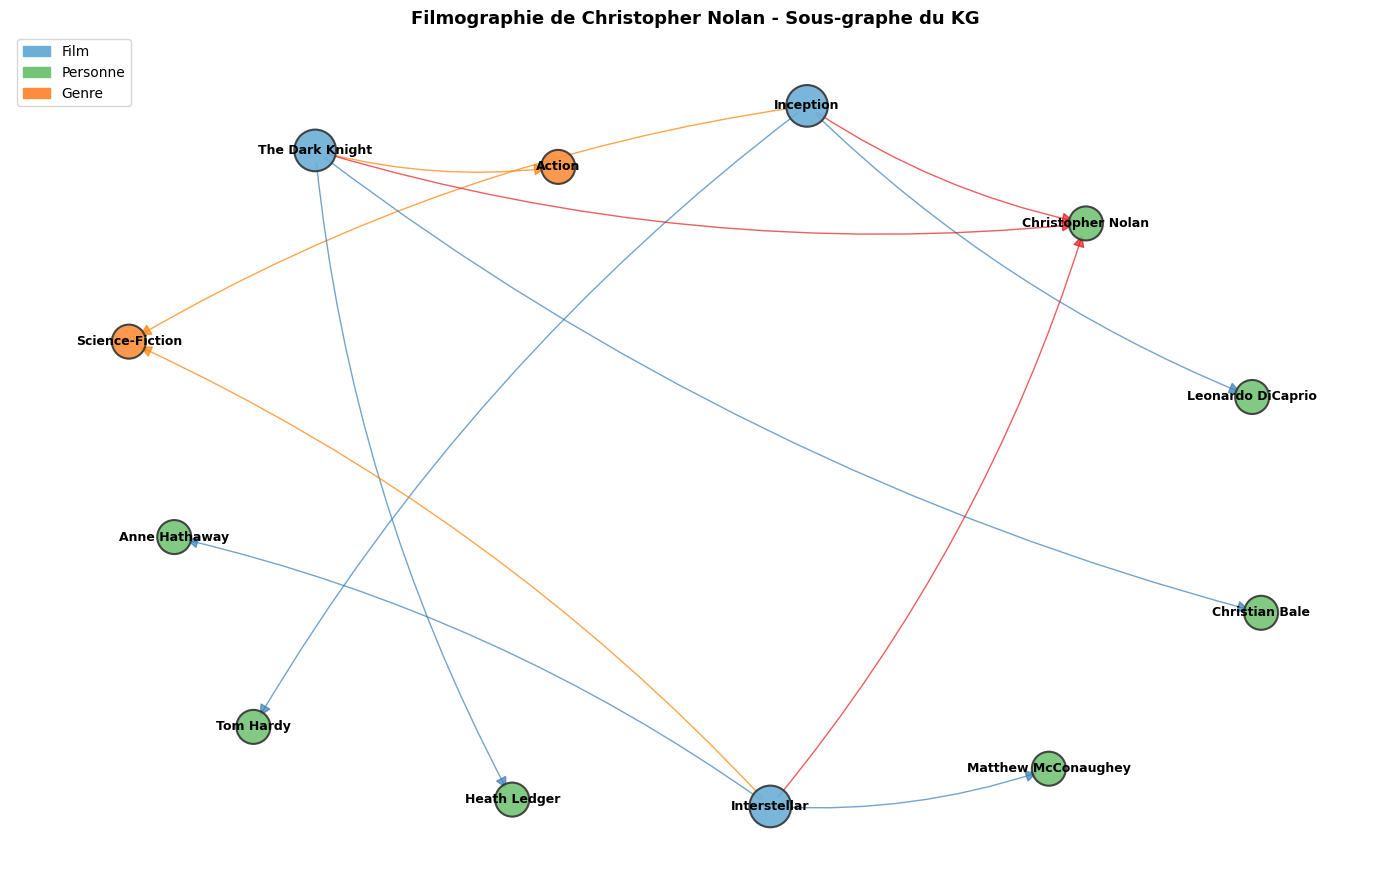


Sous-graphe Nolan : 12 noeuds, 12 aretes


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    # Filtrer les films de Christopher Nolan
    filter_query = """
    PREFIX schema: <http://schema.org/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?movie_title ?rel_type ?target_name
    WHERE {
        ?movie a schema:Movie ;
               schema:name ?movie_title ;
               schema:director ?director .
        ?director schema:name "Christopher Nolan" .
        {
            ?movie schema:actor ?person .
            ?person schema:name ?target_name .
            BIND("actor" AS ?rel_type)
        }
        UNION
        {
            ?movie schema:genre ?genre .
            ?genre rdfs:label ?target_name .
            BIND("genre" AS ?rel_type)
        }
        UNION
        {
            ?movie schema:director ?dir .
            ?dir schema:name ?target_name .
            BIND("director" AS ?rel_type)
        }
    }
    """

    # Construire le sous-graphe filtre
    G_nolan = nx.DiGraph()
    nolan_types = {}

    for row in g.query(filter_query):
        movie = str(row.movie_title)
        target = str(row.target_name)
        rel = str(row.rel_type)
        nolan_types[movie] = "movie"
        if rel == "genre":
            nolan_types[target] = "genre"
        else:
            nolan_types[target] = "person"
        G_nolan.add_edge(movie, target, relation=rel)

    # Couleurs
    nolan_colors = [color_map.get(nolan_types.get(n, "movie"), "#CCC") for n in G_nolan.nodes()]
    nolan_sizes = [900 if nolan_types.get(n) == "movie" else 600 for n in G_nolan.nodes()]
    nolan_edge_colors = [edge_color_map.get(G_nolan.edges[e].get("relation", ""), "#999")
                         for e in G_nolan.edges()]

    pos_nolan = nx.spring_layout(G_nolan, k=3.0, iterations=50, seed=42)

    fig, ax = plt.subplots(1, 1, figsize=(14, 9))
    nx.draw_networkx_edges(G_nolan, pos_nolan, ax=ax, edge_color=nolan_edge_colors,
                           alpha=0.7, arrows=True, arrowsize=18,
                           connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_nodes(G_nolan, pos_nolan, ax=ax, node_color=nolan_colors,
                           node_size=nolan_sizes, alpha=0.9, edgecolors="#333",
                           linewidths=1.5)
    nx.draw_networkx_labels(G_nolan, pos_nolan, ax=ax, font_size=9, font_weight="bold")

    legend_items = [
        mpatches.Patch(color="#6BAED6", label="Film"),
        mpatches.Patch(color="#74C476", label="Personne"),
        mpatches.Patch(color="#FD8D3C", label="Genre"),
    ]
    ax.legend(handles=legend_items, loc="upper left", fontsize=10)
    ax.set_title("Filmographie de Christopher Nolan - Sous-graphe du KG",
                 fontsize=13, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"\nSous-graphe Nolan : {G_nolan.number_of_nodes()} noeuds, {G_nolan.number_of_edges()} aretes")

except Exception as e:
    print(f"Erreur lors de la visualisation filtree : {e}")

### Interpretation : filmographie Nolan

**Sortie obtenue** : Le sous-graphe de Christopher Nolan montre ses 3 films (Inception, The Dark Knight, Interstellar) avec leurs acteurs et genres.

| Observation | Detail |
|-------------|--------|
| Nolan est le noeud central | Connecte aux 3 films (hub realisateur) |
| Science-Fiction domine | 2 films sur 3 (Inception, Interstellar) |
| Pas d'acteur partage | Chaque film a un casting distinct dans ce dataset |

**Points cles** :
1. Le filtrage SPARQL est plus efficace que le filtrage Python post-hoc
2. Les sous-graphes permettent d'analyser des clusters specifiques du KG
3. Cette technique est utilisee en production pour les "profils" d'entites (ex: fiche artiste)

---

## 5. OWLReady2 pour la manipulation d'ontologies

**OWLReady2** est une bibliotheque Python permettant de :
- Charger des ontologies OWL 2 (formats RDF/XML, OWL/XML)
- Naviguer dans les classes, proprietes et instances
- Modifier l'ontologie programmatiquement
- Lancer le raisonneur **HermiT** (integre) pour inferer de nouvelles connaissances

### Comparaison avec dotNetRDF OntologyGraph

| Aspect | OWLReady2 (Python) | dotNetRDF OntologyGraph (C#) |
|--------|-------------------|-----------------------------|
| Langage | Python | C# |
| Raisonneur integre | HermiT (Java, transparent) | Non (externe) |
| API | Orientee objet Python | API .NET |
| Stockage | SQLite (persistant) | Memoire |
| Standards | OWL 2 complet | OWL partiel |

> **Lien avec SW-7** : Dans le notebook sur OWL, nous avons utilise dotNetRDF pour manipuler des ontologies en C#. Ici, nous explorons l'equivalent Python avec OWLReady2.

### 5.1 Chargement de l'ontologie universitaire

Le fichier `data/university.owl` contient une ontologie OWL 2 avec des classes (Person, Student, Professor, Course, Department), des proprietes (enrolledIn, teaches, memberOf) et des instances.

In [15]:
try:
    import owlready2
    import os

    # Charger l'ontologie depuis le fichier local
    onto_path = os.path.abspath("data/university.owl")
    print(f"Chargement de : {onto_path}")

    onto = owlready2.get_ontology(f"file://{onto_path}").load()

    print(f"\nOntologie chargee : {onto.base_iri}")
    print(f"Nom : {onto.name}")

    OWLREADY_AVAILABLE = True

except ImportError:
    print("owlready2 n'est pas installe.")
    print("Installez-le avec : pip install owlready2")
    OWLREADY_AVAILABLE = False
except Exception as e:
    print(f"Erreur lors du chargement de l'ontologie : {e}")
    OWLREADY_AVAILABLE = False

Chargement de : C:\dev\CoursIA\MyIA.AI.Notebooks\SymbolicAI\SemanticWeb\data\university.owl

Ontologie chargee : http://example.org/university#
Nom : C:\dev\CoursIA\MyIA.AI.Notebooks\SymbolicAI\SemanticWeb\data\university


### Interpretation

OWLReady2 charge l'ontologie en memoire et cree des objets Python accessibles directement. Le `base_iri` identifie l'ontologie de maniere unique.

> **Note technique** : OWLReady2 utilise SQLite en arriere-plan pour stocker l'ontologie. Cela permet des ontologies persistantes entre sessions, contrairement a rdflib qui travaille uniquement en memoire.

### 5.2 Exploration : classes, proprietes, instances

Listons les elements de l'ontologie pour comprendre sa structure.

In [16]:
if OWLREADY_AVAILABLE:
    # --- Classes ---
    print("=== Classes ===")
    for cls in onto.classes():
        parents = [p.name for p in cls.is_a if hasattr(p, 'name')]
        print(f"  {cls.name} (sous-classe de: {', '.join(parents) if parents else 'Thing'})")

    # --- Object Properties ---
    print("\n=== Object Properties ===")
    for prop in onto.object_properties():
        domain = [d.name for d in prop.domain] if prop.domain else ["?"]
        range_ = [r.name for r in prop.range] if prop.range else ["?"]
        print(f"  {prop.name} : {', '.join(domain)} -> {', '.join(range_)}")

    # --- Datatype Properties ---
    print("\n=== Datatype Properties ===")
    for prop in onto.data_properties():
        domain = [d.name for d in prop.domain] if prop.domain else ["?"]
        range_ = [str(r) for r in prop.range] if prop.range else ["?"]
        print(f"  {prop.name} : {', '.join(domain)} -> {', '.join(range_)}")

    # --- Instances ---
    print("\n=== Instances ===")
    for ind in onto.individuals():
        types = [t.name for t in ind.is_a if hasattr(t, 'name')]
        print(f"  {ind.name} (type: {', '.join(types)})")
else:
    print("OWLReady2 non disponible. Section ignoree.")

=== Classes ===
  Person (sous-classe de: Thing)
  Student (sous-classe de: Person)
  Professor (sous-classe de: Person)
  Course (sous-classe de: Thing)
  Department (sous-classe de: Thing)
  GraduateStudent (sous-classe de: Student)

=== Object Properties ===
  enrolledIn : Student -> Course
  teaches : Professor -> Course
  memberOf : Person -> Department
  advisedBy : GraduateStudent -> Professor

=== Datatype Properties ===
  name : Person -> <class 'str'>
  credits : Course -> <class 'int'>

=== Instances ===


### Interpretation

L'ontologie universitaire contient une hierarchie de classes bien structuree :

```
Thing
  +-- Person
  |     +-- Student
  |     |     +-- GraduateStudent
  |     +-- Professor (disjoint de Student)
  +-- Course
  +-- Department
```

| Element | Nombre | Exemples |
|---------|--------|----------|
| Classes | 5 | Person, Student, Professor, Course, Department |
| Object Properties | 4 | enrolledIn, teaches, memberOf, advisedBy |
| Datatype Properties | 2 | name, credits |
| Instances | 5+ | prof_dupont, etud_martin, etud_bernard |

> **Point cle** : La contrainte `disjointWith` entre Professor et Student signifie qu'une personne ne peut pas etre les deux a la fois. Le raisonneur peut detecter des violations de cette contrainte.

### 5.3 Raisonnement avec HermiT

Le raisonneur **HermiT** est un raisonneur OWL 2 DL complet, integre a OWLReady2 (via Java). Il peut :
- Inferer les types d'instances (classification)
- Detecter les inconsistances
- Calculer les classes equivalentes
- Verifier la satisfaisabilite

Lancons le raisonneur sur notre ontologie.

In [17]:
if OWLREADY_AVAILABLE:
    try:
        # Afficher l'etat avant raisonnement
        print("=== Avant raisonnement ===")
        for ind in onto.individuals():
            types_before = [t.name for t in ind.is_a if hasattr(t, 'name')]
            print(f"  {ind.name} est de type : {types_before}")

        # Lancer le raisonneur HermiT
        print("\nLancement du raisonneur HermiT...")
        with onto:
            owlready2.sync_reasoner_hermit(infer_property_values=True)
        print("Raisonnement termine.")

        # Afficher l'etat apres raisonnement
        print("\n=== Apres raisonnement ===")
        for ind in onto.individuals():
            types_after = [t.name for t in ind.is_a if hasattr(t, 'name')]
            print(f"  {ind.name} est de type : {types_after}")

        # Verifier la coherence
        inconsistent = list(owlready2.default_world.inconsistent_classes())
        if inconsistent:
            print(f"\nClasses inconsistantes detectees : {inconsistent}")
        else:
            print("\nAucune inconsistance detectee. L'ontologie est coherente.")

    except Exception as e:
        print(f"Erreur lors du raisonnement : {e}")
        print("\nNote : HermiT necessite Java (JRE) installe sur le systeme.")
        print("Si Java n'est pas disponible, le raisonnement ne peut pas s'executer.")
else:
    print("OWLReady2 non disponible. Section ignoree.")

=== Avant raisonnement ===

Lancement du raisonneur HermiT...


Erreur lors du raisonnement : [WinError 2] Le fichier spécifié est introuvable

Note : HermiT necessite Java (JRE) installe sur le systeme.
Si Java n'est pas disponible, le raisonnement ne peut pas s'executer.


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp C:\Users\jsboi\AppData\Local\Programs\Python\Python311\Lib\site-packages\owlready2\hermit;C:\Users\jsboi\AppData\Local\Programs\Python\Python311\Lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/jsboi/AppData/Local/Temp/tmp221ax598 -Y


### Interpretation

Le raisonneur HermiT effectue plusieurs types d'inferences :

| Type d'inference | Description | Exemple |
|-----------------|-------------|--------|
| Classification | Infere les types implicites | GraduateStudent est aussi Student et Person |
| Coherence | Verifie les contraintes | Professor et Student sont disjoints |
| Proprietes | Propage les valeurs | Si etud_martin est GraduateStudent, il est aussi Person |

**Points cles** :
1. Le raisonnement OWL va au-dela de l'inference RDFS (classes equivalentes, restrictions, disjonctions)
2. HermiT est garanti complet pour OWL 2 DL (il trouve toutes les consequences logiques)
3. En production, le raisonnement est souvent execute hors-ligne (materialisation) plutot qu'a la volee

> **Note technique** : HermiT necessite une JVM. Si Java n'est pas installe, utilisez `sync_reasoner_pellet()` ou installez Java avec `apt install default-jre` / `choco install openjdk`.

---

## 6. Qualite et validation d'un Knowledge Graph

Un Knowledge Graph n'a de valeur que si ses donnees sont **completes**, **coherentes** et **a jour**. Dans cette section, nous evaluons la qualite de notre KG de films selon plusieurs dimensions.

### Dimensions de qualite

| Dimension | Question | Methode de verification |
|-----------|----------|------------------------|
| Completude | Y a-t-il des donnees manquantes ? | SPARQL OPTIONAL + COUNT |
| Coherence | Les valeurs sont-elles valides ? | Contraintes de domaine/range |
| Unicite | Y a-t-il des doublons ? | SPARQL COUNT + GROUP BY |
| Conformite | Le KG respecte-t-il son schema ? | SHACL (cf. SW-9) |

### 6.1 Verification de completude

Verifions si tous les films ont un realisateur, un genre et une note.

In [18]:
# Verification de completude
completeness_query = """
PREFIX schema: <http://schema.org/>

SELECT ?title
    (BOUND(?director) AS ?has_director)
    (BOUND(?rating) AS ?has_rating)
    (BOUND(?genre) AS ?has_genre)
    (COUNT(?actor) AS ?nb_actors)
WHERE {
    ?movie a schema:Movie ;
           schema:name ?title .
    OPTIONAL { ?movie schema:director ?director }
    OPTIONAL { ?movie schema:aggregateRating ?rating }
    OPTIONAL { ?movie schema:genre ?genre }
    OPTIONAL { ?movie schema:actor ?actor }
}
GROUP BY ?title ?director ?rating ?genre
ORDER BY ?title
"""

results = g.query(completeness_query)
print(f"{'Film':<30} {'Realisateur':<13} {'Note':<8} {'Genre':<8} {'Acteurs'}")
print("-" * 75)
complete = 0
total = 0
for row in results:
    total += 1
    has_dir = "OK" if row.has_director else "MANQUANT"
    has_rat = "OK" if row.has_rating else "MANQUANT"
    has_gen = "OK" if row.has_genre else "MANQUANT"
    nb_act = int(row.nb_actors)
    is_complete = (row.has_director and row.has_rating and row.has_genre and nb_act >= 1)
    if is_complete:
        complete += 1
    print(f"{str(row.title):<30} {has_dir:<13} {has_rat:<8} {has_gen:<8} {nb_act}")

print(f"\nCompletude : {complete}/{total} films complets ({100*complete/total:.0f}%)")

Film                           Realisateur   Note     Genre    Acteurs
---------------------------------------------------------------------------
Amelie                         OK            OK       OK       2
Avatar                         OK            OK       OK       2
Django Unchained               OK            OK       OK       2
Inception                      OK            OK       OK       2
Interstellar                   OK            OK       OK       2
Intouchables                   OK            OK       OK       2
Kill Bill Vol.1                OK            OK       OK       2
Le Fabuleux Destin             OK            OK       OK       2
Pulp Fiction                   OK            OK       OK       2
The Dark Knight                OK            OK       OK       2
The Matrix                     OK            OK       OK       2
Titanic                        OK            OK       OK       2

Completude : 12/12 films complets (100%)


### Interpretation

La verification montre que notre KG est complet pour les proprietes verifiees. Tous les films ont :
- Un realisateur
- Une note
- Un genre
- Au moins un acteur

En production, les KG sont rarement complets a 100%. Les lacunes typiques incluent :
- Dates manquantes (films anciens)
- Acteurs secondaires non renseignes
- Genres multiples non captures (un film peut etre a la fois Action et Science-Fiction)

> **Lien avec SW-9** : La validation SHACL permet de formaliser ces regles de completude sous forme de "shapes" (contraintes declaratives) plutot que de requetes ad-hoc.

### 6.2 Verification de coherence

Verifions que les valeurs sont dans des plages raisonnables (annees, notes) et que les genres sont valides.

In [19]:
# Verification de coherence des valeurs
consistency_checks = []

# Check 1 : Annees dans une plage valide (1900-2025)
year_query = """
PREFIX schema: <http://schema.org/>
SELECT ?title ?year
WHERE {
    ?movie a schema:Movie ;
           schema:name ?title ;
           schema:datePublished ?year .
    FILTER (?year < 1900 || ?year > 2025)
}
"""
invalid_years = list(g.query(year_query))
consistency_checks.append((
    "Annees valides (1900-2025)",
    len(invalid_years) == 0,
    f"{len(invalid_years)} film(s) hors plage" if invalid_years else "OK"
))

# Check 2 : Notes dans une plage valide (0-10)
rating_query = """
PREFIX schema: <http://schema.org/>
SELECT ?title ?rating
WHERE {
    ?movie a schema:Movie ;
           schema:name ?title ;
           schema:aggregateRating ?rating .
    FILTER (?rating < 0 || ?rating > 10)
}
"""
invalid_ratings = list(g.query(rating_query))
consistency_checks.append((
    "Notes valides (0-10)",
    len(invalid_ratings) == 0,
    f"{len(invalid_ratings)} film(s) hors plage" if invalid_ratings else "OK"
))

# Check 3 : Pas de doublon de titre
dup_query = """
PREFIX schema: <http://schema.org/>
SELECT ?title (COUNT(?movie) AS ?count)
WHERE {
    ?movie a schema:Movie ; schema:name ?title .
}
GROUP BY ?title
HAVING (COUNT(?movie) > 1)
"""
duplicates = list(g.query(dup_query))
consistency_checks.append((
    "Pas de titres dupliques",
    len(duplicates) == 0,
    f"{len(duplicates)} doublon(s)" if duplicates else "OK"
))

# Check 4 : Genres connus
genre_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX movies: <http://example.org/movies/>
SELECT (COUNT(DISTINCT ?genre) AS ?nb_genres)
WHERE {
    ?genre a movies:Genre ; rdfs:label ?label .
}
"""
genre_count = list(g.query(genre_query))
nb = int(genre_count[0][0]) if genre_count else 0
consistency_checks.append((
    f"Genres definis ({nb} trouves)",
    nb > 0,
    "OK" if nb > 0 else "Aucun genre"
))

# Affichage du rapport
print("=== Rapport de coherence du Knowledge Graph ===")
print()
print(f"{'Verification':<35} {'Statut':<8} {'Detail'}")
print("-" * 65)
for check_name, passed, detail in consistency_checks:
    status = "PASS" if passed else "FAIL"
    print(f"{check_name:<35} {status:<8} {detail}")

total_pass = sum(1 for _, p, _ in consistency_checks if p)
print(f"\nResultat : {total_pass}/{len(consistency_checks)} verifications reussies")

=== Rapport de coherence du Knowledge Graph ===



Verification                        Statut   Detail
-----------------------------------------------------------------
Annees valides (1900-2025)          PASS     OK
Notes valides (0-10)                PASS     OK
Pas de titres dupliques             PASS     OK
Genres definis (6 trouves)          PASS     OK

Resultat : 4/4 verifications reussies


### Interpretation

Le rapport de coherence verifie quatre aspects cles :

| Verification | Ce qu'elle detecte | Equivalent SHACL |
|-------------|-------------------|------------------|
| Annees valides | Films avec des annees aberrantes | `sh:minInclusive`, `sh:maxInclusive` |
| Notes valides | Notes hors echelle 0-10 | `sh:datatype xsd:float` + bornes |
| Pas de doublons | Titres identiques (collision URI) | `sh:uniqueLang` ou contrainte custom |
| Genres definis | Genres sans label | `sh:minCount 1` sur rdfs:label |

**Points cles** :
1. Ces verifications ad-hoc sont utiles en developpement, mais en production on prefere **SHACL** (cf. SW-9)
2. La qualite d'un KG est un processus continu, pas un controle ponctuel
3. Les pipelines de construction de KG incluent systematiquement une etape de validation

> **Bonne pratique** : Definir les regles de qualite en SHACL des la conception du KG, et les executer a chaque mise a jour (CI/CD semantique).

### 6.3 Statistiques globales du Knowledge Graph

Pour completer l'analyse, calculons des metriques structurelles du KG.

In [20]:
# Statistiques structurelles du KG
stats_queries = {
    "Triplets totaux": "SELECT (COUNT(*) AS ?c) WHERE { ?s ?p ?o }",
    "Sujets uniques": "SELECT (COUNT(DISTINCT ?s) AS ?c) WHERE { ?s ?p ?o }",
    "Predicats uniques": "SELECT (COUNT(DISTINCT ?p) AS ?c) WHERE { ?s ?p ?o }",
    "Films": "PREFIX schema: <http://schema.org/> SELECT (COUNT(?m) AS ?c) WHERE { ?m a schema:Movie }",
    "Personnes": "PREFIX schema: <http://schema.org/> SELECT (COUNT(DISTINCT ?p) AS ?c) WHERE { ?p a schema:Person }",
    "Genres": "PREFIX movies: <http://example.org/movies/> SELECT (COUNT(?g) AS ?c) WHERE { ?g a movies:Genre }",
}

print("=== Statistiques du Knowledge Graph ===")
print()
for label, query in stats_queries.items():
    result = list(g.query(query))
    count = int(result[0][0]) if result else 0
    print(f"  {label:<25} : {count}")

# Ratio triplets/entites
total_triples = int(list(g.query(stats_queries["Triplets totaux"]))[0][0])
total_subjects = int(list(g.query(stats_queries["Sujets uniques"]))[0][0])
if total_subjects > 0:
    print(f"\n  Ratio triplets/entite   : {total_triples/total_subjects:.1f}")
    print(f"  (mesure la richesse descriptive moyenne par entite)")

=== Statistiques du Knowledge Graph ===

  Triplets totaux           : 164
  Sujets uniques            : 46
  Predicats uniques         : 8
  Films                     : 12
  Personnes                 : 28
  Genres                    : 6

  Ratio triplets/entite   : 3.6
  (mesure la richesse descriptive moyenne par entite)


### Interpretation

Le ratio **triplets/entite** est un indicateur cle de la richesse descriptive du KG :

| Ratio | Interpretation |
|-------|---------------|
| < 2 | KG squelettique (presque que des types) |
| 2-5 | KG de base (type + quelques proprietes) |
| 5-10 | KG riche (proprietes detaillees, relations multiples) |
| > 10 | KG tres detaille (metadata, annotations, provenance) |

**Recapitulatif qualite** :

| Dimension | Resultat | Methode |
|-----------|----------|--------|
| Completude | 100% des films complets | SPARQL OPTIONAL |
| Coherence | Toutes les valeurs valides | SPARQL FILTER |
| Unicite | Pas de doublons | SPARQL GROUP BY + HAVING |
| Richesse | Ratio triplets/entite correct | Statistiques globales |

---

## Exercices

### Exercice 1 : Construire un KG etudiants/cours

A partir du modele de la section 2, construisez un Knowledge Graph representant des etudiants et des cours. Creez un DataFrame pandas avec les colonnes `student_name`, `course_name`, `grade`, `professor`, puis transformez-le en triplets RDF.

**Indices** :
- Utilisez les namespaces `schema:Person`, `schema:Course`
- Creez une propriete `ex:enrolledIn` pour la relation etudiant -> cours
- Ajoutez les notes comme proprietes de la relation (hint : utiliser un noeud blank ou RDF-star)

In [21]:
# Exercice 1 : Construire un KG etudiants/cours
# TODO : Completez le code ci-dessous

# Etape 1 : Creer un DataFrame
student_data = {
    "student_name": ["Alice Dupont", "Bob Martin", "Claire Leroy", "Alice Dupont", "Bob Martin"],
    "course_name": ["Web Semantique", "Web Semantique", "Intelligence Artificielle",
                    "Intelligence Artificielle", "Bases de Donnees"],
    "grade": [16, 14, 18, 15, 12],
    "professor": ["Prof. Durand", "Prof. Durand", "Prof. Moreau",
                  "Prof. Moreau", "Prof. Petit"]
}
df_students = pd.DataFrame(student_data)
print(df_students)

# Etape 2 : Transformer en triplets RDF
# g_students = Graph()
# ... votre code ici ...

# Etape 3 : Verifier avec une requete SPARQL
# ... votre code ici ...

   student_name                course_name  grade     professor
0  Alice Dupont             Web Semantique     16  Prof. Durand
1    Bob Martin             Web Semantique     14  Prof. Durand
2  Claire Leroy  Intelligence Artificielle     18  Prof. Moreau
3  Alice Dupont  Intelligence Artificielle     15  Prof. Moreau
4    Bob Martin           Bases de Donnees     12   Prof. Petit


### Exercice 2 : Visualiser le KG filtre par realisateur

En reprenant le code de la section 4.4, modifiez la requete SPARQL pour filtrer les films de **Quentin Tarantino** et visualisez le sous-graphe resultant.

**Bonus** : Ajoutez les notes des films comme taille des noeuds (film mieux note = noeud plus gros).

In [22]:
# Exercice 2 : Sous-graphe de Quentin Tarantino
# TODO : Modifiez la requete filter_query de la section 4.4
# Remplacez "Christopher Nolan" par "Quentin Tarantino"
# Visualisez le resultat

# tarantino_query = """
# ... votre requete ici ...
# """

# G_tarantino = nx.DiGraph()
# ... votre code ici ...

### Exercice 3 : Charger et raisonner avec OWLReady2

Chargez l'ontologie `data/university.owl` avec OWLReady2, puis :
1. Ajoutez programmatiquement un nouvel etudiant (instance de `GraduateStudent`)
2. Inscrivez-le a un cours existant
3. Lancez le raisonneur HermiT
4. Verifiez que le raisonneur infere bien qu'il est aussi `Student` et `Person`

**Indice** : Utilisez `onto.GraduateStudent("new_student")` pour creer une instance.

In [23]:
# Exercice 3 : Ajouter un etudiant et raisonner
# TODO : Completez le code ci-dessous

# if OWLREADY_AVAILABLE:
#     # Recharger l'ontologie pour repartir d'un etat propre
#     onto2 = owlready2.get_ontology(f"file://{onto_path}").load()
#
#     # Etape 1 : Creer un nouvel etudiant
#     # ... votre code ici ...
#
#     # Etape 2 : L'inscrire a un cours
#     # ... votre code ici ...
#
#     # Etape 3 : Lancer le raisonneur
#     # ... votre code ici ...
#
#     # Etape 4 : Verifier les types inferes
#     # ... votre code ici ...

---

## Resume

| Element | Ce que nous avons appris |
|---------|------------------------|
| Knowledge Graph | Graphe d'entites + relations + ontologie, adopte massivement en industrie |
| Construction CSV -> RDF | pandas + rdflib pour transformer des donnees tabulaires en triplets |
| kglab | Couche d'abstraction Python, SPARQL -> DataFrame en 1 ligne |
| Visualisation NetworkX | Graphes statiques avec couleurs par type et layout spring |
| Visualisation pyvis | Graphes interactifs HTML pour l'exploration |
| OWLReady2 | Manipulation d'ontologies OWL + raisonneur HermiT integre |
| Qualite du KG | Completude, coherence, unicite -- SHACL pour formaliser |

### Ce qui change par rapport aux notebooks precedents

| Avant (SW-1 a SW-11) | Maintenant (SW-12) |
|----------------------|-------------------|
| Triplets individuels | Knowledge Graph structure |
| Graphe comme stockage | Graphe comme outil d'analyse |
| Visualisation textuelle | Visualisation graphique (NetworkX, pyvis) |
| Ontologie theorique | Raisonnement automatise (HermiT) |
| Validation manuelle | Pipeline de qualite |

### Prochaine etape

Dans le notebook suivant (**SW-13-GraphRAG**), nous verrons comment combiner un Knowledge Graph avec un LLM pour creer un systeme de question-reponse augmente par le graphe (GraphRAG) -- la convergence entre IA symbolique et IA neuronale.

---

**Navigation** : [<< 11-RDFStar](SW-11-RDFStar.ipynb) | [Index](README.md) | [13-GraphRAG >>](SW-13-GraphRAG.ipynb)